# DQN Training
Training a DQN agent using custom gym environment and keras-rl2.

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from gym import Env
from gym.spaces import Discrete, Box

from rl.agents import DQNAgent
from rl.policy import MaxBoltzmannQPolicy, BoltzmannQPolicy, LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

## Functions

In [2]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w

# Environment

## Loading Shape Class

In [3]:
import sys  
sys.path.insert(0, "E:\Projects\Python\TetrisRoyaleRL")

from settings import *
from game_env.shapes import Shape
from game_env.game_env import GameEnv

## Reworking the Environment

## Define new functions

In [4]:
def heuristic(self):
        temp_map = self.map
        # sum of heights
        heights = 24 - np.argmax(temp_map[:, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS] == 1, axis=0)
        sum_hights = heights.sum()

        # bumpiness
        bumpiness = 0
        for i in range(heights.shape[0] - 1):
            bumpiness += (heights[i] - heights[i + 1]) ** 2

        # complete rows
        temp_map = temp_map[GAME_SHAPE_TOP_HIDDEN: -GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
        complete_rows = (np.where(temp_map.sum(axis=1) == 10)[0]).size

        # count of holes
        holes = 0
        for i in range(1, temp_map.shape[0]):
            for j in range(temp_map.shape[1]):
                if temp_map[i, j] == 0 and temp_map[i-1, j] == 1:
                    holes += 1

        total = -0.6 * sum_hights \
                + 0.75 * complete_rows \
                - 0.35 * holes \
                - 0.1 * bumpiness
        return total / 10

In [5]:
def new_state_observe(self):
        # observable map
        temp_map = self.map[GAME_SHAPE_TOP_HIDDEN:-GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS].copy()
        
        # observation of cur shape on map
        temp_shape = np.zeros(self.map.shape)
        x0 = self.shape.x
        y0 = int(self.shape.y)
        this_shape = self.shape.get_shape()
        temp_shape[y0: y0 + this_shape.shape[0], x0: x0 + this_shape.shape[1]] += this_shape
        temp_shape = temp_shape[GAME_SHAPE_TOP_HIDDEN:-GAME_SHAPE_BORDERS, GAME_SHAPE_BORDERS: -GAME_SHAPE_BORDERS]
        
        # next shape on map, assuming y0 = 0
        temp_next_shape = np.zeros((20, 10))
        x0 = self.next_shape.x - GAME_SHAPE_BORDERS
        next_shape = self.next_shape.get_shape()
        temp_next_shape[0: next_shape.shape[0], x0: x0 + next_shape.shape[1]] += next_shape

        return np.stack([temp_map, temp_shape, temp_next_shape], axis=-1).astype(np.float32)

In [6]:
def reward_alive(self):
    return 1

## Assign new functions

In [7]:
GameEnv._state_observe = new_state_observe
GameEnv._reward_after_lock_figure = heuristic
GameEnv._reward_for_alive = reward_alive

## Create env

In [8]:
env = GameEnv()
env.observation_space = Box(low=0.0, high=1.0, shape=(20, 10, 3))
env.gravity = 1

## Test Random

In [9]:
episodes = 25
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    steps = 0
    while not done:
        action = np.random.randint(0, 5)
        n_state, reward, done, info = env.step(action)
        score+=reward
        steps +=1
    print("Episode: {}, Score: {}, Steps: {}".format(episode, score, steps))

Episode: 1, Score: 91.53499999999997, Steps: 173
Episode: 2, Score: 112.76500000000004, Steps: 255
Episode: 3, Score: 127.92000000000003, Steps: 220
Episode: 4, Score: 64.61, Steps: 183
Episode: 5, Score: 160.31, Steps: 286
Episode: 6, Score: 162.06999999999996, Steps: 257
Episode: 7, Score: 81.01500000000001, Steps: 136
Episode: 8, Score: 85.805, Steps: 185
Episode: 9, Score: 79.095, Steps: 225
Episode: 10, Score: 177.93500000000003, Steps: 300
Episode: 11, Score: 120.21999999999998, Steps: 201
Episode: 12, Score: 119.66999999999999, Steps: 205
Episode: 13, Score: 101.67000000000002, Steps: 174
Episode: 14, Score: 102.60000000000004, Steps: 218
Episode: 15, Score: 30.865000000000013, Steps: 86
Episode: 16, Score: 94.40000000000002, Steps: 174
Episode: 17, Score: 98.04500000000009, Steps: 201
Episode: 18, Score: 87.09, Steps: 137
Episode: 19, Score: 106.31500000000001, Steps: 225
Episode: 20, Score: 195.95000000000002, Steps: 285
Episode: 21, Score: 76.67499999999998, Steps: 174
Episod

## Test do-nothing

In [10]:
episodes = 25
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    steps = 0
    while not done:
        action = -1
        n_state, reward, done, info = env.step(action)
        score+=reward
        steps +=1
    print("Episode: {}, Score: {}, Steps: {}".format(episode, score, steps))

Episode: 1, Score: 122.81000000000003, Steps: 267
Episode: 2, Score: 116.62000000000002, Steps: 226
Episode: 3, Score: 117.69000000000007, Steps: 205
Episode: 4, Score: 151.855, Steps: 247
Episode: 5, Score: 113.29499999999999, Steps: 177
Episode: 6, Score: 144.67499999999998, Steps: 226
Episode: 7, Score: 151.47, Steps: 257
Episode: 8, Score: 96.16999999999999, Steps: 173
Episode: 9, Score: 106.95499999999998, Steps: 176
Episode: 10, Score: 42.754999999999995, Steps: 190
Episode: 11, Score: 127.595, Steps: 251
Episode: 12, Score: 174.81500000000005, Steps: 289
Episode: 13, Score: 130.61499999999995, Steps: 221
Episode: 14, Score: 155.48499999999999, Steps: 223
Episode: 15, Score: 75.27499999999999, Steps: 242
Episode: 16, Score: 127.73000000000002, Steps: 268
Episode: 17, Score: 96.20000000000002, Steps: 172
Episode: 18, Score: 90.77000000000001, Steps: 178
Episode: 19, Score: 106.60000000000001, Steps: 249
Episode: 20, Score: 117.61499999999997, Steps: 183
Episode: 21, Score: 130.214

## Test to-side

In [11]:
episodes = 25
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    steps = 0
    while not done:
        action = 1
        n_state, reward, done, info = env.step(action)
        score+=reward
        steps +=1
    print("Episode: {}, Score: {}, Steps: {}".format(episode, score, steps))

Episode: 1, Score: 114.84500000000001, Steps: 151
Episode: 2, Score: 100.11500000000001, Steps: 141
Episode: 3, Score: 103.63499999999999, Steps: 144
Episode: 4, Score: 125.12999999999998, Steps: 164
Episode: 5, Score: 102.29499999999999, Steps: 143
Episode: 6, Score: 104.44000000000001, Steps: 162
Episode: 7, Score: 89.63499999999999, Steps: 145
Episode: 8, Score: 93.04499999999999, Steps: 130
Episode: 9, Score: 98.63, Steps: 150
Episode: 10, Score: 91.34, Steps: 130
Episode: 11, Score: 90.74999999999999, Steps: 137
Episode: 12, Score: 118.23000000000002, Steps: 172
Episode: 13, Score: 93.015, Steps: 136
Episode: 14, Score: 103.545, Steps: 144
Episode: 15, Score: 98.37, Steps: 140
Episode: 16, Score: 112.35000000000001, Steps: 157
Episode: 17, Score: 117.17500000000001, Steps: 159
Episode: 18, Score: 100.74499999999998, Steps: 144
Episode: 19, Score: 91.25000000000001, Steps: 136
Episode: 20, Score: 112.47999999999999, Steps: 158
Episode: 21, Score: 105.72000000000003, Steps: 153
Epis

# Nural Network and Agent

## Build model

In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
def build_model():
    return tf.keras.Sequential([
    # 1 state, 20 rows, 10 cols, 3 matricies: locked, falling and next figures
    layers.Input(shape=(1, 20, 10, 3)),
    layers.Reshape(target_shape=(20, 10, 3)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    
    layers.Dense(32),
    layers.Activation("relu"),
    
    layers.Dense(16),
    layers.Activation("relu"),
    
    layers.Dense(5)])

In [14]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 20, 10, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 20, 10, 32)        896       
                                                                 
 activation (Activation)     (None, 20, 10, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 5, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 5, 64)         18496     
                                                                 
 activation_1 (Activation)   (None, 10, 5, 64)         0         
                                                        

## Agent

In [15]:
env.observation_space.shape, env.action_space.n

((20, 10, 3), 5)

In [16]:
def build_agent(model):
    #policy = MaxBoltzmannQPolicy()
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), 
                              attr='eps',
                              value_max=0.3,
                              value_min=.001,
                              value_test=.001,
                              nb_steps=500000)
    #policy = EpsGreedyQPolicy(0.2)
    memory = SequentialMemory(limit=5000, window_length=1)
    dqn = DQNAgent(model=model, 
        memory=memory,
        policy=policy,
        nb_actions=5,
        nb_steps_warmup=256,
        batch_size=128,
        target_model_update=1000,
        enable_double_dqn=True,
        enable_dueling_network=True)
    return dqn

In [17]:
dqn = build_agent(model)
dqn.compile(tf.keras.optimizers.Adam(learning_rate=0.00001, clipnorm=1.0), metrics=["mean_squared_error"])

In [18]:
dqn.load_weights("saved/dqn_v17.h5")

from keras import backend as K
print(K.eval(dqn.model.optimizer.learning_rate))
K.set_value(dqn.model.optimizer.learning_rate, 0.00001)
print(K.eval(dqn.model.optimizer.learning_rate))

0.01
1e-05


## Training

In [19]:
history = dqn.fit(env, nb_steps=750000, visualize=False, verbose=1, log_interval=20000)

Training for 750000 steps ...
Interval 1 (0 steps performed)
  132/20000 [..............................] - ETA: 23s - reward: 0.8960

E:\Programs\Anaconda\envs\game.ai\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


20000/20000 [==============================] - 830s 41ms/step - reward: 0.5831
57 episodes - episode_reward: 201.257 [134.015, 259.560] - loss: 0.284 - mean_squared_error: 2382.624 - mean_q: 43.410 - mean_eps: 0.294

Interval 2 (20000 steps performed)
20000/20000 [==============================] - 835s 42ms/step - reward: 0.5849
56 episodes - episode_reward: 208.387 [105.265, 256.350] - loss: 0.297 - mean_squared_error: 2339.565 - mean_q: 42.824 - mean_eps: 0.282

Interval 3 (40000 steps performed)
20000/20000 [==============================] - 835s 42ms/step - reward: 0.5778
57 episodes - episode_reward: 205.783 [107.085, 309.055] - loss: 0.370 - mean_squared_error: 2352.815 - mean_q: 42.895 - mean_eps: 0.270

Interval 4 (60000 steps performed)
20000/20000 [==============================] - 836s 42ms/step - reward: 0.5867
54 episodes - episode_reward: 216.976 [105.650, 294.620] - loss: 0.309 - mean_squared_error: 2357.444 - mean_q: 42.739 - mean_eps: 0.258

Interval 5 (80000 steps per

## Save Weights

In [20]:
dqn.save_weights("saved/dqn_v18.h5", overwrite=True)

## Plot

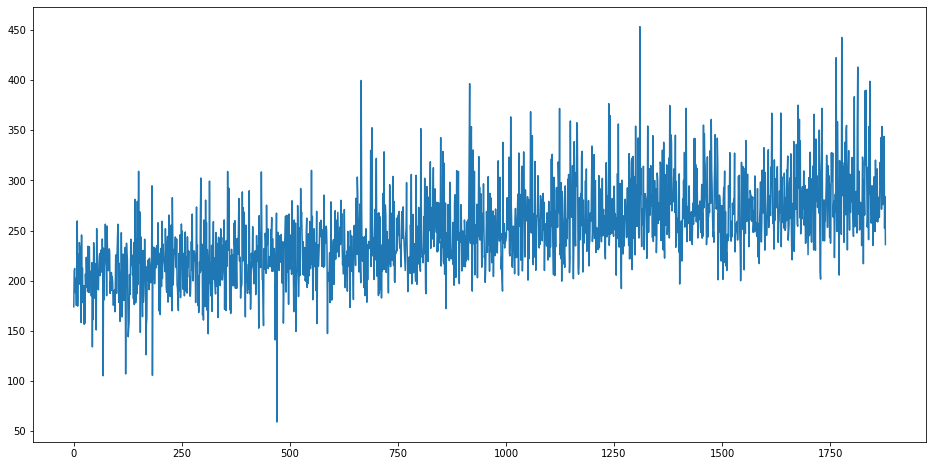

In [21]:
# load history
#full_hist = np.load("saved/history15.npy")
#full_hist = np.concatenate((full_hist, np.array(history.history["episode_reward"])))
# save history
#np.save("saved/history15.npy", full_hist)
np.save("saved/history18.npy", np.array(history.history["episode_reward"]))

plt.rcParams["figure.figsize"] = (16, 8)
#plt.plot(moving_average(full_hist, 10))
#plt.plot(full_hist)
plt.plot(np.array(history.history["episode_reward"]))
plt.show()

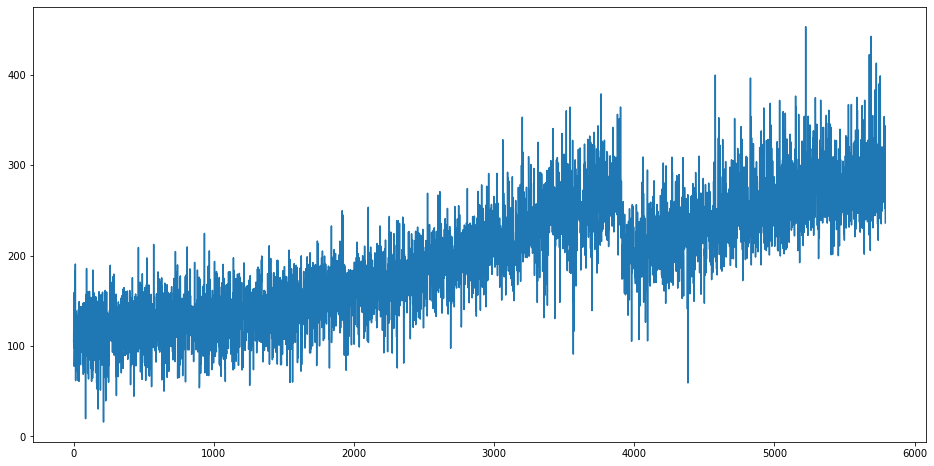

In [22]:
load17 = np.load("saved/history17.npy")
load18 = np.load("saved/history18.npy")
total = np.concatenate((load17, load18))
plt.plot(total)
plt.show()